### Purpose of this notebook:

- data exploration and visualization

In [111]:
import requests
import os
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import time
from joblib import delayed, Parallel
import datetime
# helper functions:
import helpers
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%matplotlib inline

### Let's get a sense of the data:

In [127]:
data = pd.read_csv('drug_event_sample.csv');

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


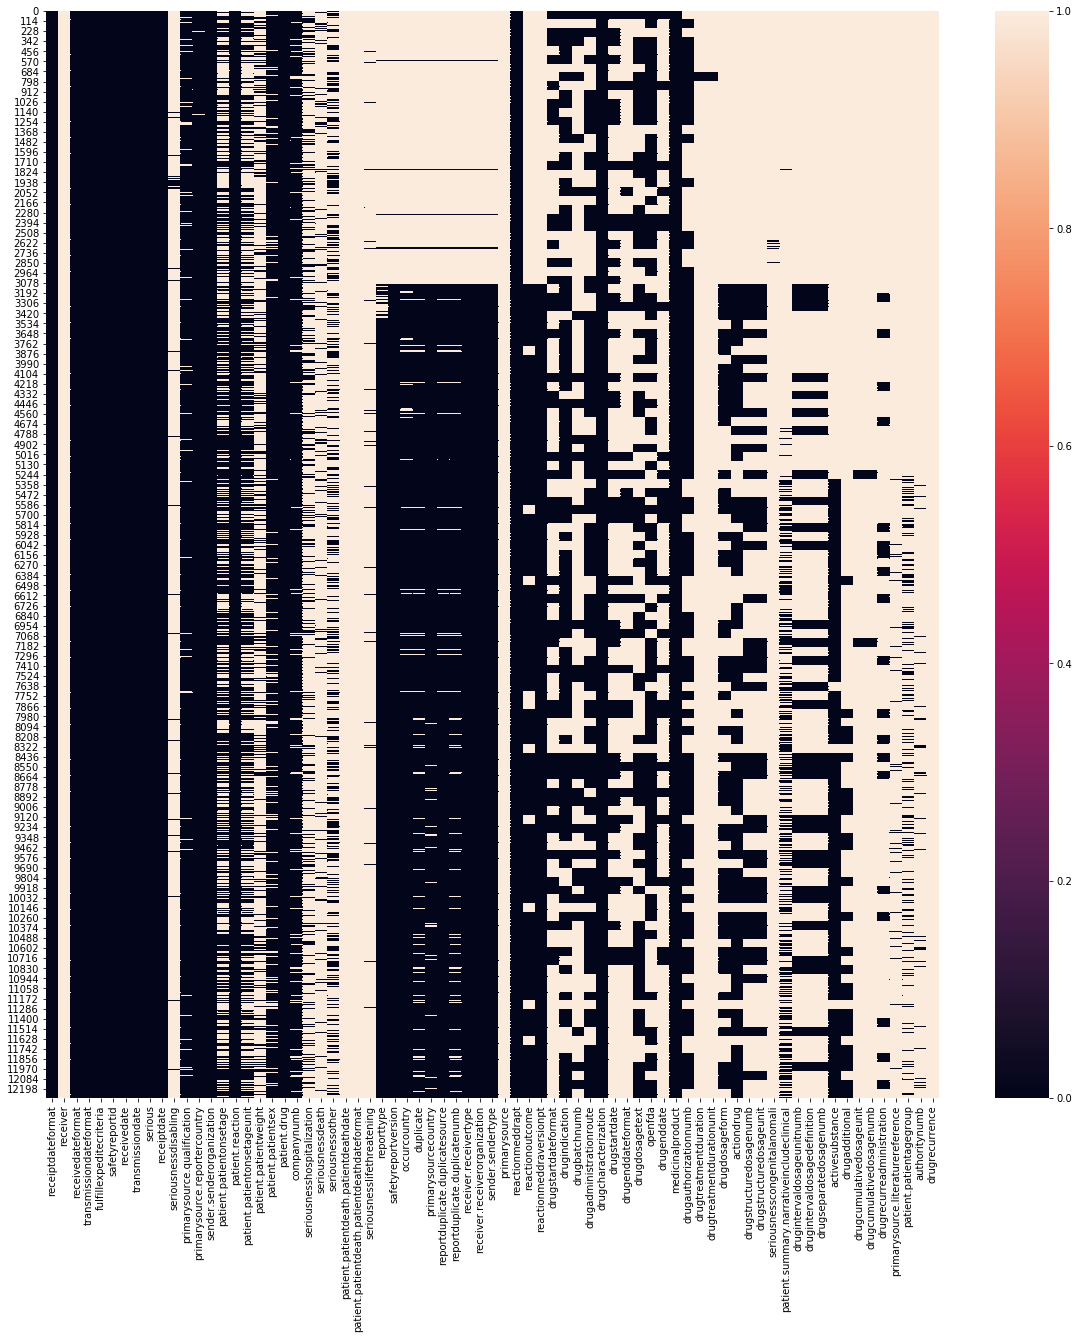

In [68]:
plt.figure(figsize=(20,20))
missing_data_count = sns.heatmap(data.isnull(), cbar = True)
#sns.barplot(data_var)
#missing_data_count. savefig("missing_data_count.png")

In [101]:
missing_df = data.isnull()

missing_df_info = pd.DataFrame(data = {'missing_count':missing_df[missing_df==True].count(axis=0)/len(data)})
data_var = pd.DataFrame(data = {'column_var':data.var(axis = 0)})
data_count =pd.DataFrame(data = {'column_count':data_subset.nunique(axis = 0)}) 

In [102]:
missing_cols = missing_df_info[missing_df_info['missing_count']==1].index
zero_var_cols = data_var[data_var['column_var']==0].index
zero_var_cols_var = data_count[data_count['column_count']==1].index
adverse_events = [col for col in data.columns if 'seriousness' in str(col)]
noninform_cols = list(set(missing_cols).union(zero_var_cols).union(data_count) - set(adverse_events))

In [104]:
data_subset = data[set(data.columns) - set(noninform_cols)]

In [109]:
data_subset.head()

,drugstartdate,openfda,companynumb,reactionmeddrapt,seriousnessdisabling,medicinalproduct,safetyreportversion,seriousnesscongenitalanomali,reportduplicate.duplicatenumb,patient.patientonsetage,drugdosageform,drugintervaldosagedefinition,reactionoutcome,patient.patientonsetageunit,drugadministrationroute,seriousnessdeath,drugenddateformat,drugcumulativedosagenumb,patient.patientweight,patient.patientsex,safetyreportid,serious,reporttype,patient.drug,receiptdate,patient.summary.narrativeincludeclinical,receivedate,primarysource.qualification,drugrecurreadministration,drugindication,occurcountry,patient.reaction,primarysourcecountry,seriousnesslifethreatening,drugstructuredosageunit,drugdosagetext,drugenddate,drugauthorizationnumb,actiondrug,receiver.receiverorganization,transmissiondate,activesubstance,sender.senderorganization,fulfillexpeditecriteria,reactionmeddraversionpt,patient.patientagegroup,drugstartdateformat,reportduplicate.duplicatesource,drugbatchnumb,authoritynumb,drugadditional,seriousnesshospitalization,primarysource.literaturereference,drugcharacterization,drugseparatedosagenumb,drugstructuredosagenumb,primarysource.reportercountry,seriousnessother,drugintervaldosageunitnumb
0,20100110.0,"{'product_ndc': ['10122-612', '10122-611', '10...",NaN,DYSPNOEA,1.0,CLEVIPREX,NaN,NaN,NaN,80.0,NaN,NaN,NaN,801.0,41.0,NaN,102.0,NaN,74.5,2.0,6569263-0,1,NaN,"[{'drugstartdateformat': '102', 'drugindicatio...",20100201,NaN,20100201,2.0,NaN,HYPERTENSION,NaN,"[{'reactionmeddrapt': 'DYSPNOEA'}, {'reactionm...",NaN,NaN,NaN,INITIAL DOSE 1MG/HR TITRATE IV DIP,20100111.0,NaN,NaN,NaN,20100710,NaN,FDA-Public Use,2,NaN,NaN,102.0,NaN,68-405-DJ,NaN,NaN,NaN,NaN,1,NaN,NaN,UNITED STATES,NaN,NaN
1,20100110.0,"{'product_ndc': ['10122-612', '10122-611', '10...",US-SANOFI-AVENTIS-2010SA003472,DYSPNOEA,NaN,CLEVIPREX,NaN,NaN,NaN,86.0,NaN,NaN,NaN,801.0,41.0,NaN,102.0,NaN,NaN,1.0,6565057-0,1,NaN,[{'drugindication': 'TYPE 2 DIABETES MELLITUS'...,20100119,NaN,20100201,5.0,NaN,HYPERTENSION,NaN,"[{'reactionmeddrapt': 'ASTHENIA'}, {'reactionm...",NaN,NaN,NaN,INITIAL DOSE 1MG/HR TITRATE IV DIP,20100111.0,NaN,NaN,NaN,20100710,NaN,FDA-Public Use,1,NaN,NaN,102.0,NaN,68-405-DJ,NaN,NaN,1.0,NaN,1,NaN,NaN,UNITED STATES,NaN,NaN
2,20100110.0,"{'product_ndc': ['10122-612', '10122-611', '10...",PHEH2010US01653,DYSPNOEA,NaN,CLEVIPREX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,1.0,102.0,NaN,NaN,1.0,6565461-0,1,NaN,"[{'drugadministrationroute': '048', 'drugchara...",20100127,NaN,20100201,NaN,NaN,HYPERTENSION,NaN,[{'reactionmeddrapt': 'DEATH'}],NaN,NaN,NaN,INITIAL DOSE 1MG/HR TITRATE IV DIP,20100111.0,NaN,NaN,NaN,20100710,NaN,FDA-Public Use,1,NaN,NaN,102.0,NaN,68-405-DJ,NaN,NaN,NaN,NaN,1,NaN,NaN,UNITED STATES,NaN,NaN
3,20100110.0,"{'product_ndc': ['10122-612', '10122-611', '10...",US-ABBOTT-09P-163-0607314-00,DYSPNOEA,NaN,CLEVIPREX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,102.0,NaN,NaN,1.0,6565799-7,2,NaN,"[{'drugindication': 'PROSTATE CANCER', 'drugba...",20091104,NaN,20100201,5.0,NaN,HYPERTENSION,NaN,[{'reactionmeddrapt': 'BONE DENSITY DECREASED'}],NaN,NaN,NaN,INITIAL DOSE 1MG/HR TITRATE IV DIP,20100111.0,NaN,NaN,NaN,20100710,NaN,FDA-Public Use,2,NaN,NaN,102.0,NaN,68-405-DJ,NaN,NaN,NaN,NaN,1,NaN,NaN,UNITED STATES,NaN,NaN
4,20100110.0,"{'product_ndc': ['10122-612', '10122-611', '10...",2010AL000504,DYSPNOEA,1.0,CLEVIPREX,NaN,NaN,NaN,37.0,NaN,NaN,NaN,801.0,41.0,NaN,102.0,NaN,NaN,1.0,6574338-6,1,NaN,"[{'drugstartdateformat': '102', 'drugindicatio...",20100118,NaN,20100201,3.0,NaN,HYPERTENSION,NaN,"[{'reactionmeddrapt': 'ABASIA'}, {'reactionmed...",NaN,NaN,NaN,INITIAL DOSE 1MG/HR TITRATE IV DIP,20100111.0,NaN,NaN,NaN,20100710,NaN,FDA-Public Use,1,NaN,NaN,102.0,NaN,68-405-DJ,NaN,NaN,1.0,NaN,1,NaN,NaN,UNITED KINGDOM,NaN,NaN


In [157]:
import json 
test = data['patient.drug'][0]#.replace('[','').replace(']','').replace('\"','').replace(' ','')

In [158]:
test

"[{'drugstartdateformat': '102', 'drugindication': 'HYPERTENSION', 'drugbatchnumb': '68-405-DJ', 'drugadministrationroute': '041', 'drugcharacterization': '1', 'drugstartdate': '20100110', 'drugenddateformat': '102', 'drugdosagetext': 'INITIAL DOSE 1MG/HR TITRATE IV DIP', 'openfda': {'product_ndc': ['10122-612', '10122-611', '10122-610'], 'package_ndc': ['10122-611-01', '10122-611-10', '10122-610-10', '10122-610-01', '10122-612-01', '10122-612-04'], 'generic_name': ['CLEVIPIDINE'], 'spl_set_id': ['f9290625-b723-4eda-bab8-a97bef6041f6'], 'brand_name': ['CLEVIPREX'], 'manufacturer_name': ['Chiesi USA, Inc.'], 'unii': ['19O2GP3B7Q'], 'rxcui': ['1790248', '1790245', '1790246', '1790247', '1790242', '1790239'], 'spl_id': ['04948b75-fd66-48df-8b8b-8930c1ec5de5'], 'substance_name': ['CLEVIDIPINE'], 'product_type': ['HUMAN PRESCRIPTION DRUG'], 'route': ['INTRAVENOUS'], 'application_number': ['NDA022156']}, 'drugenddate': '20100111', 'medicinalproduct': 'CLEVIPREX'}]"

In [145]:
n = json.dumps(test)

In [146]:
o = json.loads(n)

In [147]:
o

"{'drugstartdateformat':'102','drugindication':'HYPERTENSION','drugbatchnumb':'68-405-DJ','drugadministrationroute':'041','drugcharacterization':'1','drugstartdate':'20100110','drugenddateformat':'102','drugdosagetext':'INITIALDOSE1MG/HRTITRATEIVDIP','openfda':{'product_ndc':'10122-612','10122-611','10122-610','package_ndc':'10122-611-01','10122-611-10','10122-610-10','10122-610-01','10122-612-01','10122-612-04','generic_name':'CLEVIPIDINE','spl_set_id':'f9290625-b723-4eda-bab8-a97bef6041f6','brand_name':'CLEVIPREX','manufacturer_name':'ChiesiUSA,Inc.','unii':'19O2GP3B7Q','rxcui':'1790248','1790245','1790246','1790247','1790242','1790239','spl_id':'04948b75-fd66-48df-8b8b-8930c1ec5de5','substance_name':'CLEVIDIPINE','product_type':'HUMANPRESCRIPTIONDRUG','route':'INTRAVENOUS','application_number':'NDA022156'},'drugenddate':'20100111','medicinalproduct':'CLEVIPREX'}"

In [159]:
test2 = pd.DataFrame(data = eval(test))

In [196]:
test3 = eval(data_subset['openfda'][100])

In [197]:
test3

{'product_ndc': ['46708-025',
  '0121-0820',
  '46708-026',
  '54838-556',
  '27808-033',
  '0121-4820',
  '68462-356',
  '10135-604',
  '62332-025',
  '62332-026',
  '0378-0486',
  '0378-0487',
  '68462-380',
  '42858-701',
  '42858-702'],
 'package_ndc': ['46708-026-30',
  '68462-356-05',
  '27808-033-01',
  '68462-356-01',
  '0378-0487-01',
  '62332-025-71',
  '0121-4820-40',
  '46708-025-91',
  '0121-0820-04',
  '10135-604-08',
  '62332-025-30',
  '62332-025-31',
  '46708-026-71',
  '42858-701-01',
  '68462-380-05',
  '68462-380-01',
  '46708-025-71',
  '46708-026-31',
  '62332-026-71',
  '62332-025-91',
  '46708-025-31',
  '46708-025-30',
  '0378-0486-01',
  '62332-026-31',
  '62332-026-30',
  '0121-4820-15',
  '0121-0820-16',
  '42858-702-01',
  '54838-556-80'],
 'generic_name': ['THEOPHYLLINE', 'THEOPHYLLINE ANHYDROUS'],
 'spl_set_id': ['78a99bfe-6ebe-4ace-80b0-ee019921435e',
  '31f3c720-1597-4d43-9296-33017b90b15f',
  'bba266d2-1d22-49a9-b3db-e4f06802a8a9',
  '32b9780f-c46f-4e0

In [199]:
list_of_things = ['brand_name','manufacturer_name','route','product_type','application_number']
values = [test3.get(s) for s in list_of_things]

In [204]:
import json
from pandas.io.json import json_normalize


def loading_file():
    #File path
    file_path = 'drug_event_sample.csv'#file path here

    #Loading json file
    json_data = open(file_path)
    data = json.load(json_data)
    return data

#Storing avaliable keys
def data_keys(data):
    keys = {}
    for i in data:
        for k in i.keys():
            keys[k] = 1

    keys = keys.keys()

#Excluding nested arrays from keys - hard coded -> IMPROVE
    new_keys = [x for x in keys if
    x != 'attributes' and
    x != 'change']

    return new_keys

#Excluding nested arrays from json dictionary
def new_data(data, keys):
    new_data = []
    for i in range(0, len(data)):
        x = {k:v for (k,v) in data[i].items() if k in keys }
        new_data.append(x)
    return new_data
#def csv_out(data):
#     data.to_csv('out.csv',encoding='utf-8')

#def main():
#     data_file = loading_file()
#     keys = data_keys(data_file)
#     table = new_data(data_file, keys)
 #    csv_out(json_normalize(table))



In [211]:
data_keys(json.dumps(eval(str(test3))))

AttributeError: 'str' object has no attribute 'keys'